In [ ]:
#!pip install -U -q PyDrive
!pip install PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If you executed the cells below, you should be able to see the files df_twiiter_taal.csv under the "Files" tab on the left panel.

The tweets data is on the eruption of taal volcano. some query topic can be queried such as volcano, eruption, and volcanic ash.

The data spans 2020/01/12 to 2020/01/30 and has 16,205 tweets.

You can also download it to do some experimental observation, processing, and algorithm design.



In [ ]:
id='16IF0Zp1EyuKooWuLX_ZlCpJL78CTiwh7'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('df_tweet_taal.csv')

Load the datasets:

In [ ]:
import pandas as pd
data_name = 'df_tweet_taal'
df_tweets = pd.read_csv(data_name+'.csv', header=0)

Check the data:

In [ ]:
df_tweets.head(5)

,tweet_id,user_id,time,text,place,language,user_location,coordx,coordy,hashtags
0,1216169022393208832,958310834052112384,2020-01-12 01:24:24,I would also like to lose mass and not have as...,{'url': 'https://api.twitter.com/1.1/geo/id/00...,tl,"Gainza, Bicol Region",0.000000,0.000000,NaN
1,1216174303722512385,2409954242,2020-01-12 01:45:24,That view 😍\n\n#clubbalaiisabel #taal #batanga...,{'url': 'https://api.twitter.com/1.1/geo/id/00...,in,NaN,14.090886,121.017314,clubbalaiisabel taal batangas okgi
2,1216177167744192512,1099558236238209027,2020-01-12 01:56:46,Pa taal naaa hahaha,{'url': 'https://api.twitter.com/1.1/geo/id/01...,tl,"Padre Garcia, Calabarzon",0.000000,0.000000,NaN
3,1216202303817928705,980666256,2020-01-12 03:36:39,I like more gray hair color. Can that be ?????...,{'url': 'https://api.twitter.com/1.1/geo/id/01...,tl,"San Fernando City, Central Luz",0.000000,0.000000,NaN
4,1216214956330438656,2202356766,2020-01-12 04:26:56,Easy breezy⛰ @ Taal Volcano Tagaytay https://t...,{'url': 'https://api.twitter.com/1.1/geo/id/00...,en,"San Jose del Monte, Bulacan",14.781398,121.071233,NaN


From the data above, we can see some attributes of tweets such as time, text, and place. In the attributes of place, we can caculate the rough coordinates of the tweet, that is to computer the center point of the bounding-box in which the user post the tweet

# Problem defination and algorihtm steps

The Problem definition: 
This is some of my ideas which is also similar with yours in the writing.
Firstly, let’s recall the subject of the ureca-----finding the spreading paths from tweets, given a keyword.
So we can complete your problem statement on the objection which is to find the trajectory of given topic. That is given a query of topic (such as volcanic ash, typhon, and flooding) and find the trajectory of the topic in a region from the social media tweets.

The Basic algorithm process:
1.	To simplify the problem, we can assume we know the query topic in advance. The first step is similar with yours that is to filter out tweets, in other words classing and getting the tweets on the topic we want. You can use the term-interestingness based approach to filter out the tweets that contain keywords in query.
Here is some of my idea on this, we can try to cluster the tweets first using unsupervised ML method, and then calculate the similarity between clusters and a given query topic. In this method, the query topic is not necessary to be known in advance. So the first step is to cluster the all tweets on semantic, geographical distance, and time. 
2.	The second step is to computer the similarity between query topic and all clusters on semantic. And then we got the most top-k clusters based on your writing or set a threshold value to get cluster we want.
3.	The third step is to calculate the trajectory of the query topic based on the obtained clusters. That is to computer the centroid and link them on temporal order.
4.	The trajectory can also be valid on some spatial situation. For example, the trajectory of volcanic ash can be compared with the actual direction path of volcanic ash based on real observation, also for typhoon topic can be valid with real path observation.

The core problem is on clustering tweets based on semantic, geographical distance, and time. In the aspect of semantic, we can try word2vec method to calculate the semantic similarity. In geographical distance and time aspect, the method in you writing can be used on this.






## Track the trajectory of topic on geo-texutal data streams with cluster-based matching.

Give the sets of tweets which has the attributes of time, location, text and also the query keywords or topic we want to tack. We want to design algorithms to find the the spreading paths of the topic from tweets that is to ouput the district location sequece related. Also we can output the speading volumes of tweets squences on the topics in each location.

There are some topic spreading with the path patterns such as volcano ash, hurricane or typhoon, virus propagation, tour of majoy event, California wildﬁres and so on.

The Basic algorithm process:
1.	We try to cluster the tweets first using unsupervised ML method, and then calculate the similarity between clusters and a given query topic. In this method, the query topic is not necessary to be known in advance. So the first step is to cluster the all tweets on semantic, geographical distance, and time with the defined loss function.

   $L= \sum w_1 \times dis + w_2 \times Time + w_3 \times Semantic$ 

2.	The second step is to computer the similarity between query topic and all clusters on semantic, cluster size and time. And then we got the most top-k clusters or set a threshold value to get cluster we want.

   $S=w1 \times |cluster| + w_2 \times \sum e^{\alpha|currTim - tim|} + w_3 \times \sum semantic\_sim$

3.	The third step is to calculate the trajectory of the query topic based on the obtained clusters. That is to computer the centroid and link them on temporal order.
4.	The trajectory can also be valid on some spatial situation. For example, the trajectory of volcanic ash can be compared with the actual direction path of volcanic ash based on real observation, also for typhoon topic can be valid with real path observation.

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
from gensim.models import doc2vec
from scipy import spatial
import pandas as pd
import numpy as np
import nltk
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform

In [ ]:
# Download pretrained doc2vec model
# The pretrained doc2vec model I used is Associated Press News DBOW 
# from https://github.com/jhlau/doc2vec 
gdd.download_file_from_google_drive(file_id='1ftpcWBiABcQZldBdELCvpEMMQbgcHi5o',
                                    dest_path='./apnews_dbow.zip',
                                    unzip=True)

Unzipping...Done.


In [ ]:
model="/content/apnews_dbow/doc2vec.bin"
d2v_model = doc2vec.Doc2Vec.load(model)

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


# Data Cleaning

In [ ]:
#get coordinate from field place
# the coordinate can be estimated using the center point of the bounding box of the place where the user post the twitter. Also the place level had better
# to be on the "poi" level or "city" level.
for idx, row in df_tweets.iterrows():
    coords_dict = eval(row['place'])
    coords = coords_dict['bounding_box']['coordinates']
    left_up = [coords[0][0][0], coords[0][0][1]]
    right_down = [coords[0][2][0], coords[0][2][1]]
    df_tweets.loc[idx, 'lat'] = (left_up[1] + right_down[1])/2
    df_tweets.loc[idx, 'lon'] = (left_up[0] + right_down[0])/2

In [ ]:
df_tweets.head()

,tweet_id,user_id,time,text,place,language,user_location,coordx,coordy,hashtags,lat,lon
0,1216169022393208832,958310834052112384,2020-01-12 01:24:24,I would also like to lose mass and not have as...,{'url': 'https://api.twitter.com/1.1/geo/id/00...,tl,"Gainza, Bicol Region",0.000000,0.000000,NaN,13.640892,123.247826
1,1216174303722512385,2409954242,2020-01-12 01:45:24,That view 😍\n\n#clubbalaiisabel #taal #batanga...,{'url': 'https://api.twitter.com/1.1/geo/id/00...,in,NaN,14.090886,121.017314,clubbalaiisabel taal batangas okgi,14.069822,121.012972
2,1216177167744192512,1099558236238209027,2020-01-12 01:56:46,Pa taal naaa hahaha,{'url': 'https://api.twitter.com/1.1/geo/id/01...,tl,"Padre Garcia, Calabarzon",0.000000,0.000000,NaN,13.939445,121.181782
3,1216202303817928705,980666256,2020-01-12 03:36:39,I like more gray hair color. Can that be ?????...,{'url': 'https://api.twitter.com/1.1/geo/id/01...,tl,"San Fernando City, Central Luz",0.000000,0.000000,NaN,15.149620,120.568897
4,1216214956330438656,2202356766,2020-01-12 04:26:56,Easy breezy⛰ @ Taal Volcano Tagaytay https://t...,{'url': 'https://api.twitter.com/1.1/geo/id/00...,en,"San Jose del Monte, Bulacan",14.781398,121.071233,NaN,14.860594,121.163997


In [ ]:
df_tweets = df_tweets[df_tweets['language']=='en']

In [ ]:
df_tweets = df_tweets[['tweet_id', 'time', 'lat', 'lon', 'text']]

In [ ]:
df_tweets.shape

(5656, 5)

In [ ]:
#Tokenization, stemming/lemmatization, stop words
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    words = [x for x in words if x not in stop]
    return (" ".join(words)).strip()

df_tweets['text_p'] = df_tweets['text'].map(tweet_cleaner)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_tweets.head()

,tweet_id,time,lat,lon,text,text_p
4,1216214956330438656,2020-01-12 04:26:56,14.860594,121.163997,Easy breezy⛰ @ Taal Volcano Tagaytay https://t...,easy breezy taal volcano tagaytay
7,1216233302769594368,2020-01-12 05:39:50,13.888924,120.936362,"Taal volcano and lake, beautiful 😁 https://t.c...",taal volcano lake beautiful
10,1216238802076782592,2020-01-12 06:01:41,14.069822,121.012972,Let's pray for taal pls🥺🙏,let pray taal pls
20,1216247167016267777,2020-01-12 06:34:56,14.069822,121.012972,I pray to the people po na malapit sa crater o...,pray people po na malapit sa crater taal volca...
28,1216248286446702593,2020-01-12 06:39:22,14.069822,121.012972,I pray for everyone🙏 Taal Volcano https://t.co...,pray everyone taal volcano


In [ ]:
df_tweets.to_csv('./df_tweets_p.csv', header=True, index=False)

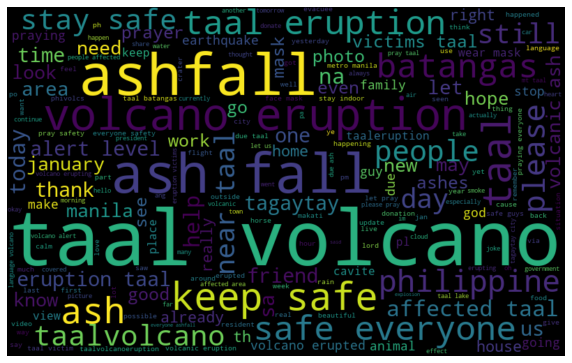

In [ ]:
#Understanding the common words used in the tweets: WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
all_words = ' '.join([text for text in df_tweets['text_p']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
import time
import datetime
from dateutil.parser import parse
def toTime(t):
    created_time = parse(t)
#    created_time.strftime("%Y/%m/%d %H:%M:%S")
    return time.mktime(created_time.timetuple())

def toLocalTime(t):
    timeStamp = float(t) 
    timeArray = time.localtime(timeStamp) 
    otherStyleTime = time.strftime("%Y-%m-%d %H:%M:%S", timeArray) 
    return otherStyleTime

df_tweets['time_unix'] = df_tweets['time'].map(lambda x: toTime(x))
df_tweets.head()

,tweet_id,time,lat,lon,text,text_p,time_unix
4,1216214956330438656,2020-01-12 04:26:56,14.860594,121.163997,Easy breezy⛰ @ Taal Volcano Tagaytay https://t...,easy breezy taal volcano tagaytay,1.578803e+09
7,1216233302769594368,2020-01-12 05:39:50,13.888924,120.936362,"Taal volcano and lake, beautiful 😁 https://t.c...",taal volcano lake beautiful,1.578808e+09
10,1216238802076782592,2020-01-12 06:01:41,14.069822,121.012972,Let's pray for taal pls🥺🙏,let pray taal pls,1.578809e+09
20,1216247167016267777,2020-01-12 06:34:56,14.069822,121.012972,I pray to the people po na malapit sa crater o...,pray people po na malapit sa crater taal volca...,1.578811e+09
28,1216248286446702593,2020-01-12 06:39:22,14.069822,121.012972,I pray for everyone🙏 Taal Volcano https://t.co...,pray everyone taal volcano,1.578811e+09


In [ ]:
tweets = df_tweets[['text_p', 'lat', 'lon', 'time_unix', 'tweet_id']]
tweets = tweets.reset_index(drop=True)
tweets.head()

,text_p,lat,lon,time_unix,tweet_id
0,easy breezy taal volcano tagaytay,14.860594,121.163997,1.578803e+09,1216214956330438656
1,taal volcano lake beautiful,13.888924,120.936362,1.578808e+09,1216233302769594368
2,let pray taal pls,14.069822,121.012972,1.578809e+09,1216238802076782592
3,pray people po na malapit sa crater taal volca...,14.069822,121.012972,1.578811e+09,1216247167016267777
4,pray everyone taal volcano,14.069822,121.012972,1.578811e+09,1216248286446702593


In [ ]:
tweets.to_csv('./df_tweets_p.csv', header=True, index=False)

In [ ]:
print(tweets['lat'].min(), tweets['lat'].max())

8.721481650000001 18.5307141


In [ ]:
print(tweets['time_unix'].min(), tweets['time_unix'].max())

1578803216.0 1580372884.0


In [ ]:
print(tweets['lon'].min(), tweets['lon'].max())

118.780801 126.26893695


In [ ]:
from math import sin, asin, cos, radians, fabs, sqrt

EARTH_RADIUS = 6371  # 地球平均半径，6371km


def hav(theta):
    s = sin(theta / 2)
    return s * s


def get_distance_hav(lat0, lng0, lat1, lng1):
    "用haversine公式计算球面两点间的距离。"
    # 经纬度转换成弧度
    lat0 = radians(lat0)
    lat1 = radians(lat1)
    lng0 = radians(lng0)
    lng1 = radians(lng1)

    dlng = fabs(lng0 - lng1)
    dlat = fabs(lat0 - lat1)
    h = hav(dlat) + cos(lat0) * cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * asin(sqrt(h))
    return distance

get_distance_hav(8.721481650000001, 118.780801, 18.5307141, 126.26893695)

1357.4194591527073

In [ ]:
np.linalg.norm(np.array([8.721481650000001, 118.780801])-np.array([18.5307141, 126.26893695]))

12.340713968965305

In [ ]:
tweets['time_unix'].min()

1578803216.0

In [ ]:
tweets['time_unix'].max() - tweets['time_unix'].min()

1569668.0

In [ ]:
datapoints = tweets.values

In [ ]:
from scipy import spatial
t1 = 'ashes keep coming taal volcano keep safe everyone'
v1 = d2v_model.infer_vector(t1.split())
t2 = 'pray everyone taal volcano'
v2 = d2v_model.infer_vector(t2.split())
distance = spatial.distance.euclidean(v1, v2)
cos_distance = spatial.distance.cosine(v1, v2)
print(distance,cos_distance)

300

# The KMediod1

In [ ]:
import pandas as pd
from gensim.models import doc2vec
from scipy import spatial
import pandas as pd
import numpy as np
import nltk
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform

df_tweets = pd.read_csv('./df_tweets_p.csv', header=0)
df_tweets = df_tweets[['text_p', 'lat', 'lon', 'time_unix', 'tweet_id']]
print(df_tweets.head())
datapoints = df_tweets.iloc[:10, :4].values

model = "./apnews_dbow/doc2vec.bin"
d2v_model = doc2vec.Doc2Vec.load(model)


def init_medoids(X, k):
  from numpy.random import choice
  from numpy.random import seed

  seed(1)
  samples = choice(len(X), size=k, replace=False)
  return X[samples, :]

medoids_initial = init_medoids(datapoints, 3)

def text_similarity(X, i, medoids):
    L = []
    for a in range(len(medoids)):
        object_text = X[i, 0]
        medoids_text = medoids[a, 0]

        vec1 = d2v_model.infer_vector(object_text.split())
        vec2 = d2v_model.infer_vector(medoids_text.split())

        # use cosine function to calculate similarity score
        distance = spatial.distance.euclidean(vec1, vec2)
        L.append(distance)

    L = np.array(L)
    return L

def compute_d_p(X, medoids):
  m = len(X)
  medoids_shape = medoids.shape
  if len(medoids_shape) == 1:
    medoids = medoids.reshape((1, len(medoids)))
  k = len(medoids)

# calculate euclidean maximum distance in this space
  D = pdist(X[:,1:3])
  max_dis = np.max(D)

  S = np.empty((m, k))
  for i in range(m):
    time_ = abs(X[i,3]-medoids[:,3].astype(float))
    time_cost = time_ / 1569668.0
    # calculate euclidean distance between object and medoids
    dis = np.linalg.norm(X[i,1:3].astype(float) - medoids[:,1:3].astype(float), axis=1)
    dis_cost = dis/max_dis
    # x_coordinate = np.deg2rad(np.array(X[i, 1:3]))
    # m_coordinate = np.deg2rad(np.array(medoids[:, 1:3]))
    # dis = haversine_distances(x_coordinate, m_coordinate)[0] * 6371
    #
    # dis_cost = dis / 1357.0
    text_cost = text_similarity(X, i, medoids)
    # I don't know how to select parameters

    cost = 0.4*dis + 0.2*time_cost + 0.4*text_cost
    S[i, :] = cost

  return S

S = compute_d_p(datapoints, medoids_initial)

def assign_labels(S):
  return np.argmin(S, axis=1)

labels = assign_labels(S)

def update_medoids(X, medoids):
    S = compute_d_p(datapoints, medoids)
    labels = assign_labels(S)

    out_medoids = medoids

    for i in set(labels):
      # calculate cost in each cluster and sum them together
        total_cost = np.sum(np.min(compute_d_p(datapoints, medoids),axis=1))

        for datap in np.array([x for x in datapoints if x not in out_medoids]):
            new_medoid = out_medoids
            new_medoid[i] = datap
            # calculate total cost of new medoids
            new_cost = np.sum(np.min(compute_d_p(datapoints, new_medoid),axis=1))

            if new_cost < total_cost:
                total_cost = new_cost

                out_medoids[i] = datap

    return out_medoids

def has_converged(old_medoids, medoids):
    return set([tuple(x) for x in old_medoids]) == set([tuple(x) for x in medoids])


def kmedoids(X, k, starting_medoids=None, max_steps=500):
    if starting_medoids is None:
        medoids = init_medoids(X, k)
    else:
        medoids = starting_medoids

    converged = False
    labels = np.zeros(len(X))
    i = 1
    while (not converged) and (i <= max_steps):
        old_medoids = medoids.copy()

        S = compute_d_p(X, medoids)

        labels = assign_labels(S)

        medoids = update_medoids(X, medoids)

        converged = has_converged(old_medoids, medoids)
        i += 1
    return (i, medoids, labels)

# try k=5
import time
t1 = time.time()
results = kmedoids(datapoints, 3)
print(time.time()-t1)
print(results)

                                              text_p  ...             tweet_id
0                  easy breezy taal volcano tagaytay  ...  1216214956330438656
1                        taal volcano lake beautiful  ...  1216233302769594368
2                                  let pray taal pls  ...  1216238802076782592
3  pray people po na malapit sa crater taal volca...  ...  1216247167016267777
4                         pray everyone taal volcano  ...  1216248286446702593

[5 rows x 5 columns]


/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


810.613508939743
(501, array([['taal volcano erupting lord please keep us harm', 14.3294441,
        120.89954795, 1578812032.0],
       ['shet alert level taal volcano immediately please keep everyone safe',
        14.683012349999998, 121.06273529999999, 1578812316.0],
       ['everyone near taal volcano please safe stay alert', 14.40788295,
        121.03131, 1578811939.0]], dtype=object), array([2, 2, 2, 2, 2, 0, 1, 1, 2, 0]))


# The KMediod2

Dealing with initialization for k-means:
* do multiple runs and select the clustering withe smallest error
* select original set of points by methods other than random.
* limitation: Differing Sizes, Differing density, Non-globular shapes. one solution is to use many clusters and need to put together parts of clusters.
* O(nkId) number of points, number of clusters, number of interations, dimensionality.

In [ ]:
import pandas as pd
from gensim.models import doc2vec
from scipy import spatial
import pandas as pd
import numpy as np
import nltk
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import haversine_distances

# self train a doc2vec and customize the dimension
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
def text_split(x):
    x = x.split(" ")
    return x

df_tweets = pd.read_csv('./df_tweets_p.csv', header=0)
df_tweets = df_tweets[['text_p', 'lat', 'lon', 'time_unix', 'tweet_id']]
df_tweets['text_p'] = df_tweets['text_p'].map(text_split)
print(df_tweets.shape)

documents_o = df_tweets['text_p'].values
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(documents_o)]
model = Doc2Vec(vector_size=30, window=1, min_count=1, workers=6, epochs=20)   
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=20)
# model.save("d2v.model")

# add a column of the vector after word embedding in the dataframe
# this is to reduce some calculation in later for loops 
def infer_vector(x):
    x = model.infer_vector(x)
    return x

df_tweets['text_v'] = df_tweets['text_p'].map(infer_vector)
df_tweets.head()

(5656, 5)


,text_p,lat,lon,time_unix,tweet_id,text_v
0,"[easy, breezy, taal, volcano, tagaytay]",14.860594,121.163997,1.578803e+09,1216214956330438656,"[-0.18635076, 0.14547898, 0.015421968, -0.0392..."
1,"[taal, volcano, lake, beautiful]",13.888924,120.936362,1.578808e+09,1216233302769594368,"[0.018142235, 0.04751264, -0.04404355, -0.0129..."
2,"[let, pray, taal, pls]",14.069822,121.012972,1.578809e+09,1216238802076782592,"[-0.11819521, 0.05580805, -0.02357073, -0.0110..."
3,"[pray, people, po, na, malapit, sa, crater, ta...",14.069822,121.012972,1.578811e+09,1216247167016267777,"[-0.15558334, 0.14610527, -0.06645639, -0.0295..."
4,"[pray, everyone, taal, volcano]",14.069822,121.012972,1.578811e+09,1216248286446702593,"[-0.013906602, 0.06684491, -0.061399583, -0.01..."


In [ ]:
# convert lat/lon to cartesian coordinates
!pip install utm
import utm
def convet_car(lat, lon):
    x1, y1, ZONE, u = utm.from_latlon(lat, lon)
    return [x1, y1]

df_tweets['carte_coor'] = df_tweets.apply(lambda x: convet_car(x['lat'], x['lon']), axis=1)
df_tweets['coorX'] = df_tweets['carte_coor'].map(lambda x: x[0])
df_tweets['coorY'] = df_tweets['carte_coor'].map(lambda x: x[1])
df_tweets.head(2)

  Created wheel for utm: filename=utm-0.7.0-cp37-none-any.whl size=6096 sha256=970afc9f6ac7c11efc8be1af38de2d31409b30b88469d04b55e08a3dd9e8681f
  Stored in directory: /root/.cache/pip/wheels/d3/a0/c4/93c7535fe705e70d2376505fd2683f91524a50a944a15212d9
Successfully built utm


,text_p,lat,lon,time_unix,tweet_id,text_v,carte_coor,coorX,coorY
0,"[easy, breezy, taal, volcano, tagaytay]",14.860594,121.163997,1.578803e+09,1216214956330438656,"[-0.18635076, 0.14547898, 0.015421968, -0.0392...","[302459.1504881542, 1643719.1018572215]",302459.150488,1.643719e+06
1,"[taal, volcano, lake, beautiful]",13.888924,120.936362,1.578808e+09,1216233302769594368,"[0.018142235, 0.04751264, -0.04404355, -0.0129...","[276996.5810112052, 1536406.2294575155]",276996.581011,1.536406e+06


In [ ]:
df_tweets1 = df_tweets[['text_p', 'text_v', 'coorX', 'coorY', 'time_unix', 'lat', 'lon']]
# datapoints = df_tweets1.iloc[:2000,:].values
datapoints = df_tweets1.values
D = pdist(datapoints[:,2:4], metric='euclidean')
max_dis = np.max(D)   #meters

maxtime_inter = df_tweets1['time_unix'].max() - df_tweets1['time_unix'].min()

# model = "./apnews_dbow/doc2vec.bin"  ## time cost for 100 sample cluster to 3 parts: 288s
# model = doc2vec.Doc2Vec.load(model)

X_ = datapoints.copy()

from sklearn.datasets import make_blobs
from matplotlib import pyplot
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D


class KMediod():
    """
    实现简单的k-medoid算法
    """

    def __init__(self, k_num_center):
        self.k_num_center = k_num_center
        self.data = X_

    def text_similarity(self, X, medoids):
        L = []
        for a in range(len(medoids)):
            object_text = X[0, 1]
            medoids_text = medoids[a, 1]

            #vec1 = model.infer_vector(object_text)
            #vec2 = model.infer_vector(medoids_text)

            # use cosine function to calculate text distance score
            distance = spatial.distance.cosine(object_text, medoids_text)
            #distance = spatial.distance.euclidean(vec1, vec2)
            L.append(distance)

        L = np.array(L)
        return L

    def ou_distance(self, X, medoids):
        # 定义距离的计算
        X = np.array([X])
        medoids_shape = medoids.shape

        if len(medoids_shape) == 1:
            medoids = medoids.reshape((1, len(medoids)))

        time_ = abs(X[:, 4] - medoids[:, 4]).astype(float)
        time_cost = time_ / maxtime_inter

        dis = spatial.distance.euclidean(X[:, 2:4],  medoids[:, 2:4])
        dis = dis / max_dis

        text_cost = self.text_similarity(X, medoids)

        cost = 0.5 * dis + 0.15 * time_cost + 0.35 * text_cost

        return cost

    def run_k_center(self, func_of_dis):
        """
        选定好距离公式开始进行训练
        :param func_of_dis:
        :return:
        """
        print('初始化', self.k_num_center, '个中心点')
        indexs = list(range(len(self.data)))
        random.shuffle(indexs)  # 随机选择质心
        init_centroids_index = indexs[:self.k_num_center]
        centroids = self.data[init_centroids_index, :]  # 初始中心点
        # 确定种类编号
        #levels = list(range(self.k_num_center))
        print('开始迭代')
        sample_target = []
        if_stop = False
        while (not if_stop):
            if_stop = True
            classify_points = [[centroid] for centroid in centroids]
            sample_target = []
            # 遍历数据(traverse data)
            for sample in self.data:
                # 计算距离，由距离该数据最近的核心，确定该点所属类别 
                distances = [func_of_dis(sample, centroid) for centroid in centroids]
                cur_level = np.argmin(distances)
                sample_target.append(cur_level)
                # 统计，方便迭代完成后重新计算中间点
                classify_points[cur_level].append(sample)
          
            # 重新划分质心
            for i in range(self.k_num_center):  # 几类中分别寻找一个最优点
                distances = [func_of_dis(point_1, centroids[i]) for point_1 in classify_points[i]]
                now_distances = sum(distances)  # 首先计算出现在中心点和其他所有点的距离总和
                for point in classify_points[i]:
                    distances = [func_of_dis(point_1, point) for point_1 in classify_points[i]]
                    new_distance = sum(distances)
                    # 计算出该聚簇中各个点与其他所有点的总和，若是有小于当前中心点的距离总和的，中心点去掉
                    if new_distance < now_distances:
                        now_distances = new_distance
                        centroids[i] = point  # 换成该点
                        if_stop = False
        print('结束')
        # print(np.around(centroids[centroids[:, 2].argsort()], decimals=1))
        self.finel_c = centroids
        return sample_target

    def run(self):
        """
        先获得数据，由传入参数得到杂乱的n个点，然后由这n个点，分为m个类
        :return:
        """

        predict = self.run_k_center(self.ou_distance)
        return (predict, self.finel_c)

import time
t1 = time.time()
test_one = KMediod(k_num_center=20)
results = test_one.run()
print(time.time()-t1)
import pickle
pickle.dump(results, open('./results.pkl', 'wb'))
# print(results)
## time cost for 2000 sample cluster to 20 parts: 115.49s

初始化 20 个中心点
开始迭代
结束
909.8825542926788


In [ ]:
import pickle
results = pickle.load(open('./results.pkl', 'rb'))

## score function 1

In [ ]:
query_topic = 'volcanic ash'
num_cluters = 20
vec2 = model.infer_vector(query_topic.split(" "))
currTime = time.time()
maxtime = currTime - df_tweets1['time_unix'].min()

def score_func(k):
    score = []
    for i in range(k):
        cluster_size = results[0].count(i)
        idx_lst = [index for index, v in enumerate(results[0]) if v == i]
        tm_score = 0
        text_score = 0
        for item in idx_lst:
            #time decay parameter -1
            tm_score += np.exp(-(currTime-datapoints[item,4]))
            # object_text = datapoints[i, 0]
            # vec1 = model.infer_vector(object_text)
            vec1 = datapoints[item, 1]
            distance = spatial.distance.cosine(vec1, vec2)
            text_score += distance
        #total_cost = 0.2*cluster_size + 0.2*tm_score + 0.6*text_score
        #avg_score = 0.2*cluster_size/len(datapoints) + 0.2*tm_score/cluster_size + 0.6*text_score/cluster_size
        avg_score = 0.2*tm_score/cluster_size + 0.8*text_score/cluster_size
        score.append(avg_score)
    return score

In [ ]:
score_time = time.time()
score = score_func(num_cluters)
print("score time:", time.time()-score_time)
cluster_df = pd.DataFrame(data=results[1], columns=['text_p', 'text_v', 'coorX', 'coorY', 'time_unix', 'lat', 'lon'])
cluster_df['score']=score
cluster_df['label']=[i for i in range(num_cluters)]
cluster_df.sort_values('score',ascending=False).head(10)

score time: 0.3492910861968994


,text_p,text_v,coorX,coorY,time_unix,lat,lon,score,label
2,"[keep, safe, residents, near, taal, volcano]","[-0.041967083, 0.042795174, -0.07489356, -0.11...",285604,1.60212e+06,1.57885e+09,14.4834,121.011,0.799521,2
1,"[praying, melody, safety, co, horses, pets, an...","[-0.22447981, 0.11530627, -0.18865728, -0.1151...",291493,1.60436e+06,1.57892e+09,14.5041,121.065,0.740878,1
6,"[possible, hazardous, explosive, eruption, taa...","[-0.035824623, 0.14878185, 0.07662018, -0.0148...",288080,1.60908e+06,1.57884e+09,14.5465,121.033,0.671666,6
7,"[comex, brigade, accepting, donations, evacuee...","[-0.1394641, 0.096860096, 0.037080705, -0.1281...",282818,1.6141e+06,1.57909e+09,14.5915,120.984,0.497429,7
3,"[taalvolcanoeruption, ash, fall, real]","[-0.09726528, 0.0027870373, 0.0116531, -0.0679...",290789,1.60791e+06,1.57883e+09,14.5361,121.058,0.462181,3
11,"[lighting, candle, deeply, praying, brothers, ...","[-0.37430272, 0.24075297, -0.07268361, -0.1486...",293410,1.61311e+06,1.57887e+09,14.5833,121.082,0.401658,11
5,"[without, n, masks, use, pleated, surgical, ma...","[-0.4129627, -0.16578875, 0.34663793, -0.10684...",291493,1.60436e+06,1.57885e+09,14.5041,121.065,0.343035,5
13,"[ok, explosives, news, morning, eruption, taal...","[-0.073267914, 0.14224167, 0.040302373, -0.114...",288080,1.60908e+06,1.57887e+09,14.5465,121.033,0.333737,13
9,[ashfall],"[-0.024130227, 0.018184278, 0.017531734, -0.03...",282818,1.6141e+06,1.57984e+09,14.5915,120.984,0.279494,9
14,"[jadine, breaking, taal, erupting, du, possibl...","[-0.30069423, 0.23517723, 0.07384637, -0.08065...",288080,1.60908e+06,1.58008e+09,14.5465,121.033,0.246756,14


In [ ]:
print(datapoints.shape)

(5656, 7)


In [ ]:
sort_cluster = cluster_df.sort_values('score',ascending=False)
top_cluster = sort_cluster.iloc[:8, :]
top_cluster

,text_p,text_v,coorX,coorY,time_unix,lat,lon,score,label
2,"[keep, safe, residents, near, taal, volcano]","[-0.041967083, 0.042795174, -0.07489356, -0.11...",285604,1.60212e+06,1.57885e+09,14.4834,121.011,0.799521,2
1,"[praying, melody, safety, co, horses, pets, an...","[-0.22447981, 0.11530627, -0.18865728, -0.1151...",291493,1.60436e+06,1.57892e+09,14.5041,121.065,0.740878,1
6,"[possible, hazardous, explosive, eruption, taa...","[-0.035824623, 0.14878185, 0.07662018, -0.0148...",288080,1.60908e+06,1.57884e+09,14.5465,121.033,0.671666,6
7,"[comex, brigade, accepting, donations, evacuee...","[-0.1394641, 0.096860096, 0.037080705, -0.1281...",282818,1.6141e+06,1.57909e+09,14.5915,120.984,0.497429,7
3,"[taalvolcanoeruption, ash, fall, real]","[-0.09726528, 0.0027870373, 0.0116531, -0.0679...",290789,1.60791e+06,1.57883e+09,14.5361,121.058,0.462181,3
11,"[lighting, candle, deeply, praying, brothers, ...","[-0.37430272, 0.24075297, -0.07268361, -0.1486...",293410,1.61311e+06,1.57887e+09,14.5833,121.082,0.401658,11
5,"[without, n, masks, use, pleated, surgical, ma...","[-0.4129627, -0.16578875, 0.34663793, -0.10684...",291493,1.60436e+06,1.57885e+09,14.5041,121.065,0.343035,5
13,"[ok, explosives, news, morning, eruption, taal...","[-0.073267914, 0.14224167, 0.040302373, -0.114...",288080,1.60908e+06,1.57887e+09,14.5465,121.033,0.333737,13


In [ ]:
label_l = top_cluster['label'].tolist()
time_sort_cluster = top_cluster.sort_values('time_unix',ascending=True)
time_sort_cluster

,text_p,text_v,coorX,coorY,time_unix,lat,lon,score,label
3,"[taalvolcanoeruption, ash, fall, real]","[-0.09726528, 0.0027870373, 0.0116531, -0.0679...",290789,1.60791e+06,1.57883e+09,14.5361,121.058,0.462181,3
6,"[possible, hazardous, explosive, eruption, taa...","[-0.035824623, 0.14878185, 0.07662018, -0.0148...",288080,1.60908e+06,1.57884e+09,14.5465,121.033,0.671666,6
5,"[without, n, masks, use, pleated, surgical, ma...","[-0.4129627, -0.16578875, 0.34663793, -0.10684...",291493,1.60436e+06,1.57885e+09,14.5041,121.065,0.343035,5
2,"[keep, safe, residents, near, taal, volcano]","[-0.041967083, 0.042795174, -0.07489356, -0.11...",285604,1.60212e+06,1.57885e+09,14.4834,121.011,0.799521,2
11,"[lighting, candle, deeply, praying, brothers, ...","[-0.37430272, 0.24075297, -0.07268361, -0.1486...",293410,1.61311e+06,1.57887e+09,14.5833,121.082,0.401658,11
13,"[ok, explosives, news, morning, eruption, taal...","[-0.073267914, 0.14224167, 0.040302373, -0.114...",288080,1.60908e+06,1.57887e+09,14.5465,121.033,0.333737,13
1,"[praying, melody, safety, co, horses, pets, an...","[-0.22447981, 0.11530627, -0.18865728, -0.1151...",291493,1.60436e+06,1.57892e+09,14.5041,121.065,0.740878,1
7,"[comex, brigade, accepting, donations, evacuee...","[-0.1394641, 0.096860096, 0.037080705, -0.1281...",282818,1.6141e+06,1.57909e+09,14.5915,120.984,0.497429,7


## score function 2

In [ ]:
query_topic = 'volcanic ash'
vec2 = model.infer_vector(query_topic.split(" "))
currTime = time.time()
maxtime = currTime - df_tweets1['time_unix'].min()

def centroid_score(x):
    return spatial.distance.cosine(x, vec2)

def rel_score(rel_cluster):
    score = []
    for i in rel_cluster['label'].values:
          vec_cen = rel_cluster.loc[rel_cluster['label']==i,'text_v'].to_list()[0]
          cluster_size = results[0].count(i)
          idx_lst = [index for index, v in enumerate(results[0]) if v == i]
          tm_score = 0
          text_score = 0
          for item in idx_lst:
              #time decay parameter -1
              tm_score += np.exp(-(currTime-datapoints[item,4])/maxtime)
              # object_text = datapoints[i, 0]
              # vec1 = model.infer_vector(object_text)
              vec1 = datapoints[item, 1]
              distance = spatial.distance.cosine(vec1, vec_cen)
              text_score += distance
          #total_cost = 0.2*cluster_size + 0.2*tm_score + 0.6*text_score
          #avg_score = 0.2*cluster_size/len(datapoints) + 0.2*tm_score/cluster_size + 0.6*text_score/cluster_size
          avg_score = 0.2*tm_score/cluster_size + 0.8*text_score/cluster_size
          score.append(avg_score)
    return score

In [ ]:
num_cluters = 20
cluster_df = pd.DataFrame(data=results[1], columns=['text_p', 'text_v', 'coorX', 'coorY', 'time_unix', 'lat', 'lon'])
cluster_df['label']=[i for i in range(num_cluters)]
cluster_df['cen_score'] = cluster_df['text_v'].map(centroid_score)
cluster_df.sort_values("cen_score", ascending=False)

,text_p,text_v,coorX,coorY,time_unix,lat,lon,label,cen_score
4,"[lord, calm, storm, even, calm, taal, volcano,...","[-0.030700227, 0.069070235, 0.102294065, -0.06...",288080,1.60908e+06,1.57884e+09,14.5465,121.033,4,0.730365
2,"[yasss, walang, pasok, safe, guys, reminder, s...","[-0.32569358, 0.22738254, 0.14145033, -0.25507...",288768,1.61331e+06,1.57884e+09,14.5848,121.039,2,0.509689
9,"[help, taal, victims]","[-0.027400121, 0.08740754, 0.015206246, 0.0667...",301029,1.55344e+06,1.57932e+09,14.0447,121.157,9,0.486380
14,"[grabe, getting, worse, hope, everyone, safe, ...","[-0.034400325, -0.05599734, 0.06888226, -0.051...",280051,1.56144e+06,1.57882e+09,14.1154,120.963,14,0.438515
16,"[kilometers, taal, region, eruptioned, happene...","[-0.36230832, 0.2759621, 0.19253914, -0.044709...",316676,1.53759e+06,1.57889e+09,13.9024,121.303,16,0.265674
7,"[abo, colon, look, kath, gold]","[-0.31811574, 0.2163311, 0.1726237, -0.0257264...",603224,1.14485e+06,1.57987e+09,10.3553,123.943,7,0.259368
3,"[amidst, ongoing, evacuation, citizens, displa...","[-0.09981547, 0.0887449, 0.073549874, 0.095362...",303569,1.54178e+06,1.57905e+09,13.9394,121.182,3,0.250921
8,"[jadine, breaking, taal, erupting, du, possibl...","[-0.3905349, 0.2614933, 0.16865286, 0.02982760...",288080,1.60908e+06,1.58008e+09,14.5465,121.033,8,0.249096
19,"[yessss, add, taal, never, tagged, inactive, c...","[-0.33370367, 0.2957588, 0.21126305, -0.007045...",291391,1.62416e+06,1.57891e+09,14.683,121.063,19,0.242565
12,"[sorry, collectively, taal, volcano]","[-0.10729013, 0.07737225, 0.063560106, -0.0303...",592692,1.14698e+06,1.57884e+09,10.3748,123.847,12,0.241591


In [ ]:
rel_cluster = cluster_df[cluster_df['cen_score']>0.2]
score = rel_score(rel_cluster)
rel_cluster['score']=score
sort_cluster = rel_cluster.sort_values('score',ascending=False)
top_cluster = sort_cluster.iloc[:7, :]
top_cluster

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,text_p,text_v,coorX,coorY,time_unix,lat,lon,label,cen_score,score
14,"[grabe, getting, worse, hope, everyone, safe, ...","[-0.034400325, -0.05599734, 0.06888226, -0.051...",280051,1.56144e+06,1.57882e+09,14.1154,120.963,14,0.438515,0.261622
12,"[sorry, collectively, taal, volcano]","[-0.10729013, 0.07737225, 0.063560106, -0.0303...",592692,1.14698e+06,1.57884e+09,10.3748,123.847,12,0.241591,0.231509
11,"[taal, volcano, complex, volcano, second, acti...","[-0.09239117, -0.004837653, 0.031844653, 0.068...",293410,1.61311e+06,1.57889e+09,14.5833,121.082,11,0.238487,0.225051
9,"[help, taal, victims]","[-0.027400121, 0.08740754, 0.015206246, 0.0667...",301029,1.55344e+06,1.57932e+09,14.0447,121.157,9,0.486380,0.217657
4,"[lord, calm, storm, even, calm, taal, volcano,...","[-0.030700227, 0.069070235, 0.102294065, -0.06...",288080,1.60908e+06,1.57884e+09,14.5465,121.033,4,0.730365,0.212056
2,"[yasss, walang, pasok, safe, guys, reminder, s...","[-0.32569358, 0.22738254, 0.14145033, -0.25507...",288768,1.61331e+06,1.57884e+09,14.5848,121.039,2,0.509689,0.208972
6,"[keep, safe, ya, ashfall]","[-0.1319215, 0.03269504, 0.050574042, -0.07665...",282818,1.6141e+06,1.57984e+09,14.5915,120.984,6,0.206468,0.206485


In [ ]:
label_l = top_cluster['label'].tolist()
time_sort_cluster = top_cluster.sort_values('time_unix',ascending=True)
time_sort_cluster

,text_p,text_v,coorX,coorY,time_unix,lat,lon,label,cen_score,score
14,"[grabe, getting, worse, hope, everyone, safe, ...","[-0.034400325, -0.05599734, 0.06888226, -0.051...",280051,1.56144e+06,1.57882e+09,14.1154,120.963,14,0.438515,0.261622
2,"[yasss, walang, pasok, safe, guys, reminder, s...","[-0.32569358, 0.22738254, 0.14145033, -0.25507...",288768,1.61331e+06,1.57884e+09,14.5848,121.039,2,0.509689,0.208972
4,"[lord, calm, storm, even, calm, taal, volcano,...","[-0.030700227, 0.069070235, 0.102294065, -0.06...",288080,1.60908e+06,1.57884e+09,14.5465,121.033,4,0.730365,0.212056
12,"[sorry, collectively, taal, volcano]","[-0.10729013, 0.07737225, 0.063560106, -0.0303...",592692,1.14698e+06,1.57884e+09,10.3748,123.847,12,0.241591,0.231509
11,"[taal, volcano, complex, volcano, second, acti...","[-0.09239117, -0.004837653, 0.031844653, 0.068...",293410,1.61311e+06,1.57889e+09,14.5833,121.082,11,0.238487,0.225051
9,"[help, taal, victims]","[-0.027400121, 0.08740754, 0.015206246, 0.0667...",301029,1.55344e+06,1.57932e+09,14.0447,121.157,9,0.486380,0.217657
6,"[keep, safe, ya, ashfall]","[-0.1319215, 0.03269504, 0.050574042, -0.07665...",282818,1.6141e+06,1.57984e+09,14.5915,120.984,6,0.206468,0.206485


# visualization

In [ ]:
l_data = pd.DataFrame(data=datapoints, columns=['text_p', 'text_v', 'coorX', 'coorY', 'time_unix', 'lat', 'lon'])
l_data['label'] = results[0]
l_data = l_data[l_data['label'].isin(label_l)]
import folium
import branca.colormap as cmp

linear = cmp.LinearColormap(
    ['yellow', 'green', 'purple'],
    vmin=0, vmax=10,
    caption='Color Scale for Map' #Caption for Color scale or Legend
)


def generateBaseMap(default_location=[13.9567,  120.976], default_zoom_start=8):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

base_map = generateBaseMap()
for index, row in l_data.iterrows():
    coordinate = [row['lat'], row['lon']]
    folium.CircleMarker(coordinate,
                        radius=4,
                        color=linear(row['label']),
                       ).add_to(base_map)
linear.add_to(base_map)
coordinates_o = sort_cluster[['lat', 'lon']].values
print(len(coordinates_o))
for i in coordinates_o:
    folium.RegularPolygonMarker(location=i, fill_color='blue', 
                                number_of_sides=3, radius=10, rotation=90).add_to(base_map)
base_map

20


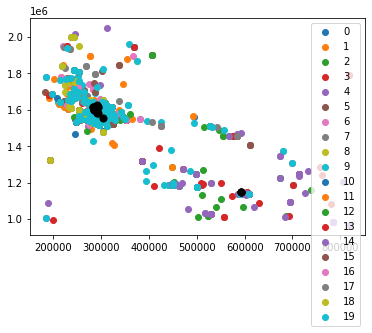

In [ ]:
import matplotlib.pyplot as plt
l_data = pd.DataFrame(data=datapoints, columns=["text_p", "text_v", "lat","lon","time_unix"])
l_data['label'] = results[0]
label = results[0]
u_labels = np.unique(label)

for i in u_labels:
    plt.scatter(l_data.loc[l_data['label']==i,'lat'] , l_data.loc[l_data['label']==i,'lon'] , label = i)
plt.scatter(cluster_df['lat'] , cluster_df['lon'] , s = 50, color = 'k')
plt.legend()
plt.show()

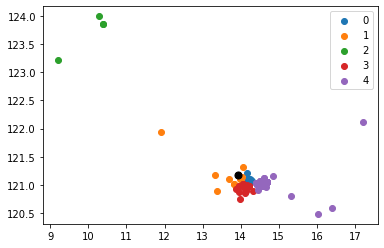

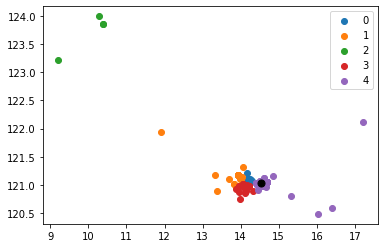

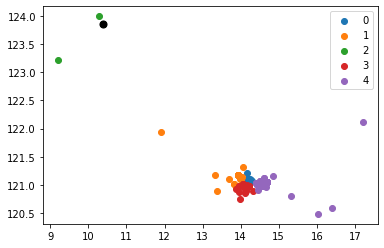

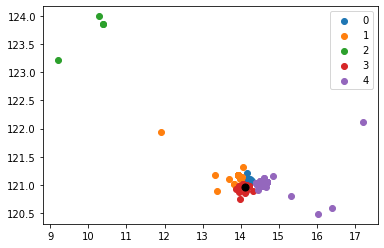

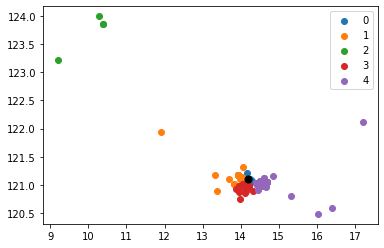

In [ ]:
for a in range(5):
  for i in u_labels:
      plt.scatter(l_data.loc[l_data['label']==i,'lat'] , l_data.loc[l_data['label']==i,'lon'] , label = i)
  plt.scatter(cluster_df.iloc[a]['lat'] , cluster_df.iloc[a]['lon'] , s = 50, color = 'k')
  plt.legend()
  plt.show()

# DBSCAN
In density based clustering we partition points into dense regions separated by not-so-dense regions.
* Density at point p: number of points within a circle of radius Eps
* Dense Region: A circle of radius Eps that contains at least
MinPts points

Not work well: Varying densities, High-dimensional data, sensitive to parameters Eps, MinPts.

In [ ]:
df_tweets1 = df_tweets[['text_v', 'lat', 'lon', 'time_unix']]
df_tweets2 = pd.DataFrame(df_tweets1['text_v'].tolist())
df_tweets2 = df_tweets2.add_prefix('text_')
df_tweets3 = pd.concat([df_tweets2, df_tweets1[['lat', 'lon', 'time_unix']]], axis=1)
df_tweets3.head()

,text_0,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,text_10,text_11,text_12,text_13,text_14,text_15,text_16,text_17,text_18,text_19,text_20,text_21,text_22,text_23,text_24,text_25,text_26,text_27,text_28,text_29,lat,lon,time_unix
0,0.179733,0.127820,-0.156315,-0.073698,-0.065770,0.198274,0.162843,-0.222595,-0.078556,0.006101,-0.053186,-0.115729,-0.080369,-0.123734,-0.186298,0.333028,-0.131679,-0.128673,0.086697,-0.017112,-0.006455,0.195819,-0.047144,-0.110960,-0.004742,-0.051527,0.013962,0.089084,0.185224,-0.095867,14.860594,121.163997,1.578803e+09
1,0.068342,0.019441,-0.098571,-0.047716,-0.055551,0.024827,0.002325,-0.146372,-0.060056,-0.025256,0.013208,0.042608,0.046013,0.051799,-0.065711,0.041680,-0.000348,-0.024251,0.018880,0.029617,0.013718,-0.025697,0.018886,0.003738,0.110929,0.074631,-0.071010,-0.005026,0.092417,-0.057974,13.888924,120.936362,1.578808e+09
2,-0.009474,0.006175,-0.032191,0.012443,-0.043018,0.000492,0.027498,-0.057407,-0.029569,-0.061572,-0.017943,-0.069171,0.050771,-0.013618,0.000141,0.129604,-0.023033,-0.017000,0.020419,0.050883,0.026292,0.011935,-0.084820,-0.047247,-0.066943,-0.062305,-0.038204,0.006888,-0.003523,-0.029788,14.069822,121.012972,1.578809e+09
3,0.056477,-0.016330,-0.150697,0.049540,-0.070672,-0.101379,0.070255,-0.039650,-0.015372,-0.125266,-0.085140,-0.137851,0.196137,-0.078585,-0.011710,0.264957,0.054388,-0.086466,0.100839,0.106636,0.088657,0.033130,-0.133735,-0.037669,-0.081889,-0.191484,-0.023669,0.116810,0.058710,0.046638,14.069822,121.012972,1.578811e+09
4,0.052060,-0.071662,-0.080130,-0.033914,-0.022865,-0.061845,-0.002197,-0.033694,0.004043,-0.059168,-0.055563,-0.052710,0.093746,-0.017987,0.030802,0.063655,0.007506,0.019987,0.036028,0.068538,0.013543,-0.045131,-0.107488,-0.006872,0.019302,-0.068279,-0.058287,0.025702,-0.006527,0.020755,14.069822,121.012972,1.578811e+09


In [ ]:
import numpy
datapoints = df_tweets3.iloc[:200,:].values

def MyDBSCAN(X, eps, MinPts):
    # initial all labes are 0
    # label -1 means a noise point
    # label 0 means havn't visited yet
    labels = [0]*len(X)
    # C is the ID of the current cluster
    C = 0

    for i in range(0, len(X)):
        if not (labels[i] == 0):
           continue
        
        # find all neighboring points of X[i]
        NeighborPts = regionQuery(X, i, eps)
        
        # if number is below MinPts, this point is noise
        if len(NeighborPts) < MinPts:
            labels[i] = -1
        # else use this point as the seed for a new cluster.    
        else: 
           C += 1
           growCluster(X, labels, i, NeighborPts, C, eps, MinPts)
    
    return labels


def growCluster(X, labels, i, NeighborPts, C, eps, MinPts):
    labels[i] = C
    
    j = 0
    while j < len(NeighborPts):    
        
        # next_i indicates the index of the next point        
        next_i = NeighborPts[j]
       
        # if next_i is a noise
        if labels[next_i] == -1:
           labels[next_i] = C
        
        elif labels[next_i] == 0:
            labels[next_i] = C
            
            # find all the neighbors of next_i
            nextP_NeighborPts = regionQuery(X, next_i, eps)
            
            # if the number is larger than MinPts, it's a branch point
            if len(nextP_NeighborPts) >= MinPts:
                NeighborPts = NeighborPts + nextP_NeighborPts  
            # else it's a leaf point        
        
        j += 1  


def regionQuery(X, i, eps):
    neighbors = []
    
    # for each point in the dataset
    for k in range(0, len(X)):
        time_ = abs(X[i][-1] - X[k][-1])
        time_cost = time_ / 1569668

        i_coordinate = np.deg2rad(np.array(X[i][-3:-1].astype(float)))
        k_coordinate = np.deg2rad(np.array(X[k][-3:-1].astype(float)))
        dis = haversine_distances([i_coordinate, k_coordinate])[0,1] * 6371
        dis = dis / 1357

        text_cost = spatial.distance.cosine(X[i][:30], X[k][:30])

        cost = 0.4 * dis + 0.2 * time_cost + 0.4 * text_cost
      
        # If the distance is below the threshold, add it to the neighbors list.
        if cost < eps:
           neighbors.append(k)
            
    return neighbors

curr_time = time.time()
my_labels = MyDBSCAN(datapoints, eps=0.1, MinPts=10)
print(time.time()-curr_time)

2.787477731704712


In [ ]:
my_labels

[1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]